In [1]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt

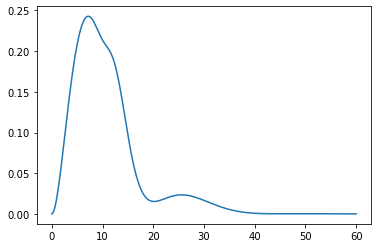

In [3]:
##############
# PARAMETERS #
##############

pi = np.pi
delta_a = 0
delta_c = 0
g = 25*2*pi*1e-3
Omega_0 = 50*2*pi*1e-3
k_a = 29*2*pi*1e-3
gamma = 1*2*pi*1e-3
N_max = 15
dim = (2)*(N_max+1)
t0 = 10
F = 5
sigma = 0.42466090014400953*F
#Omega = np.exp(-0.5*((t-t0)/sigma)**2)


##############################
# MATRIX BASIS  AND OPERATORS#
##############################

gs_k = np.array([[1],[0]])
gs_b = gs_k.transpose()
es_k = np.array([[0],[1]])
es_b = es_k.transpose()

ident2 = np.identity(2)
ident_Fock = np.identity(N_max+1)

def delta_k(n,m):
    if n == m:
        return 1
    if n != m:
        return 0

def a_op():
    a_OP = np.array([], dtype=np.complex128)
    for m in range(0, N_max+1):
        for n in range(0, N_max+1):
            a_OP = np.append(a_OP, np.sqrt(n)*delta_k(m,n-1))
    a_OP = a_OP.reshape((N_max+1, N_max+1))
    return a_OP

def ad_op():
    ad_OP = np.array([], dtype=np.complex128)
    for m in range(0, N_max+1):
        for n in range(0, N_max+1):
            ad_OP = np.append(ad_OP, np.sqrt(n+1)*delta_k(m,n+1))
    ad_OP = ad_OP.reshape((N_max+1, N_max+1))
    return ad_OP

sigma_p = np.array([[0,0],[1,0]], dtype=np.complex128)
sigma_m = np.array([[0,1],[0,0]], dtype=np.complex128)
sigma_z = np.array([[-1,0],[0,1]], dtype=np.complex128)

###################
# Temporal scales #
###################

t_50 = np.linspace(0, 60, 301)

###############
# HAMILTONIAN #
###############

def hamilt(t):
    term1 = delta_c*np.kron(np.dot(ad_op(), a_op()), ident2)
    term2 = delta_a*np.kron(ident_Fock, np.dot(sigma_p, sigma_m))
    term3 = (1j)*g*(np.kron(ad_op(), sigma_m)-np.kron(a_op(),sigma_p))
    term4 = (1j)*np.sqrt(k_a)*(np.kron(a_op(), ident2)-np.kron(ad_op(), ident2))
    ham = term1 + term2 + term3 + Omega_0*np.exp(-0.5*((t-t0)/sigma)**2) * term4
    return ham

###############
# GAUSSIAN EM #
###############

def gauss_field(t, F):
    t0 = 10
    sigma = 0.42466090014400953*F
    Omega = np.exp(-0.5*((t-t0)/sigma)**2)
    return Omega

##########################
# FREQUENCY OF THE LASER #
##########################

Omega = Omega_0*gauss_field(t_50,5)

#####################
# INITIAL CONDITION #
#####################

rho_init_1 = np.zeros((dim,dim), dtype=np.complex128)
rho_init_1[0,0] = 1 + 0j

rho_init_2 = np.zeros((dim,dim), dtype=np.complex128)
rho_init_2[1,1] = 1 + 0j


#######################################
# RIGHT SIDE OF THE LINDBLAD EQUATION #
#######################################

def right_part(rho, t):
    HAM = hamilt(t)
    term1 = -(1j)*(np.dot(HAM, rho) - np.dot(rho, HAM))
    term2 = k_a*(2*np.dot(np.dot(np.kron(a_op(), ident2), rho), np.kron(ad_op(), ident2)) - np.dot(np.kron(np.dot(ad_op(), a_op()), ident2), rho) - np.dot(rho, np.kron(np.dot(ad_op(), a_op()), ident2)))
    term3 = gamma*(2*np.dot(np.dot(np.kron(ident_Fock, sigma_m), rho), np.kron(ident_Fock, sigma_p)) - np.dot(np.kron(ident_Fock, np.dot(sigma_p, sigma_m)), rho) - np.dot(rho, np.kron(ident_Fock, np.dot(sigma_p, sigma_m))))
    
    return term1 + term2 + term3 

######################################
# Solutions of the Lindblad Equation #
######################################

sol_50 = odeintw(right_part, rho_init_2, t_50)

##########################################################################
# Getting the population elements of the reduced density matrix solution #
##########################################################################

p11_50 = np.array([])
for i in range(0,len(sol_50)):
    p11_50 =np.append(p11_50, sol_50[i,0,0])    

p22_50 = np.array([])
for i in range(0,len(sol_50)):
    p22_50 =np.append(p22_50, sol_50[i,1,1])    

p33_50 = np.array([])
for i in range(0,len(sol_50)):
    p33_50 =np.append(p33_50, sol_50[i,2,2]) 

#########    
# PLOTS #   
#########

plt.plot(t_50, p33_50.real)
#plt.plot(t_50, Omega)
plt.show()

In [4]:
photon_number_op = np.kron(np.dot(ad_op(), a_op()), ident2)
mean_photon_number = np.dot(sol_50, photon_number_op)
cavity_transmission = np.array([])
for i in range(0,len(sol_50)):
    cavity_transmission = np.append(cavity_transmission, np.trace(mean_photon_number[i]).real)

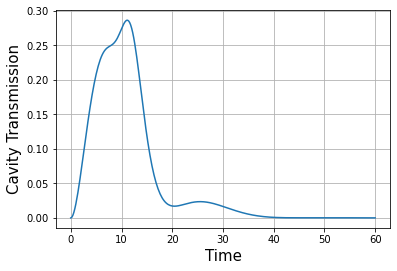

In [5]:
plt.plot(t_50, cavity_transmission)
plt.xlabel("Time",size=15)
plt.ylabel("Cavity Transmission",size=15)
plt.grid()
plt.show()

In [ ]:
p11_50

In [ ]:
hamilt(0.2).shape

In [ ]:
np.kron(ad_op(), ident2).real

In [ ]:
t_50